In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets, transforms

mnist_trainset = datasets.MNIST(root='./data', download=True, transform=transforms.ToTensor())


In [ ]:
import math

def calc_H_out_conv2d(H_in, kernel_size, stride, padding):
    return math.floor((H_in + 2 * padding - kernel_size) / stride + 1)

def calc_H_out_conv2d_transpose(H_in, kernel_size, stride, padding):
    return (H_in - 1) * stride - 2 * padding + kernel_size


In [ ]:
print(calc_H_out_conv2d(28, 15, 1, 1))
print(calc_H_out_conv2d(16, 3, 2, 1))
print(calc_H_out_conv2d(8, 3, 2, 1))
print(calc_H_out_conv2d(4, 5, 2, 1))

16
8
4
1


In [ ]:
# our encoder make 64x1x1 tensor from 1x28x28 tensor

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=15, stride=1, padding=1)     # 8x16x16
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)     # 16x8x8
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)     # 32x4x4
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=1)     # 64x1x1




    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        return x

In [ ]:
print(calc_H_out_conv2d_transpose(1, 4, 1, 0))
print(calc_H_out_conv2d_transpose(4, 2, 2, 0))
print(calc_H_out_conv2d_transpose(8, 2, 2, 0))
print(calc_H_out_conv2d_transpose(16, 4, 2, 3))


4
8
16
28


In [ ]:
# our decoder make 1x28x28 tensor from 64x1x1 tensor

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=1, padding=0)       # 32x4x4
        self.conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0)       # 16x8x8
        self.conv3 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2, padding=0)       # 8x16x16
        self.conv4 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=4, stride=2, padding=3)         # 1x28x28

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()


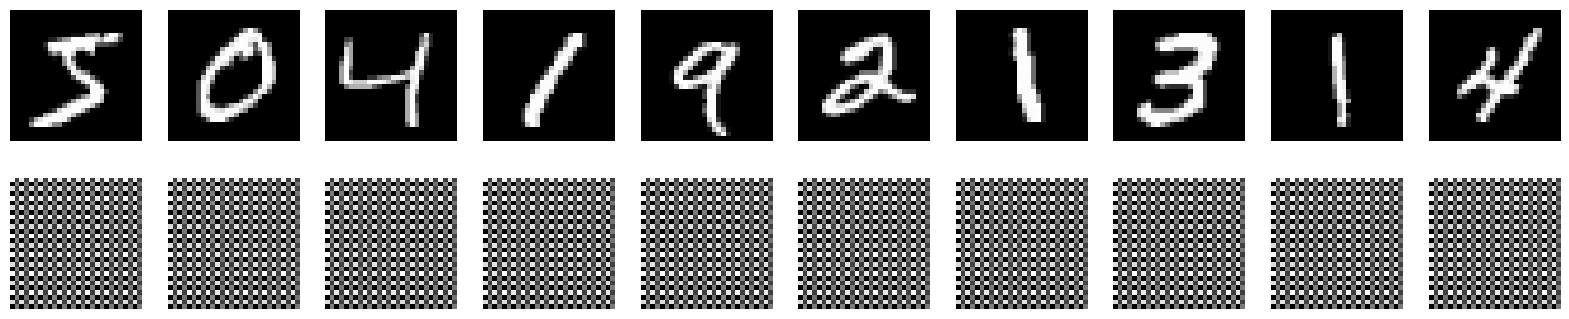

In [ ]:
# show 10 image from dataset and their reconstruction from untrained model

fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    img, _ = mnist_trainset[i]
    axs[0, i].imshow(img[0], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(model(img.unsqueeze(0)).detach().numpy()[0][0], cmap='gray')
    axs[1, i].axis('off')

plt.show()

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

n_epochs = 15

# train model

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, img)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_loader)
    print(f'epoch [{epoch+1}/{n_epochs}], loss:{average_loss}')

epoch [1/15], loss:0.023555512339870136
epoch [2/15], loss:0.012673150365054607
epoch [3/15], loss:0.011971092863877614
epoch [4/15], loss:0.011628647781908513
epoch [5/15], loss:0.01144217794885238
epoch [6/15], loss:0.011320363669594128
epoch [7/15], loss:0.011222977006435394
epoch [8/15], loss:0.01117893209507068
epoch [9/15], loss:0.011078289244075615
epoch [10/15], loss:0.010972484146058559
epoch [11/15], loss:0.010945189071943362
epoch [12/15], loss:0.010822304077198109
epoch [13/15], loss:0.01078684969469905
epoch [14/15], loss:0.010738407388826211
epoch [15/15], loss:0.010695413602143527


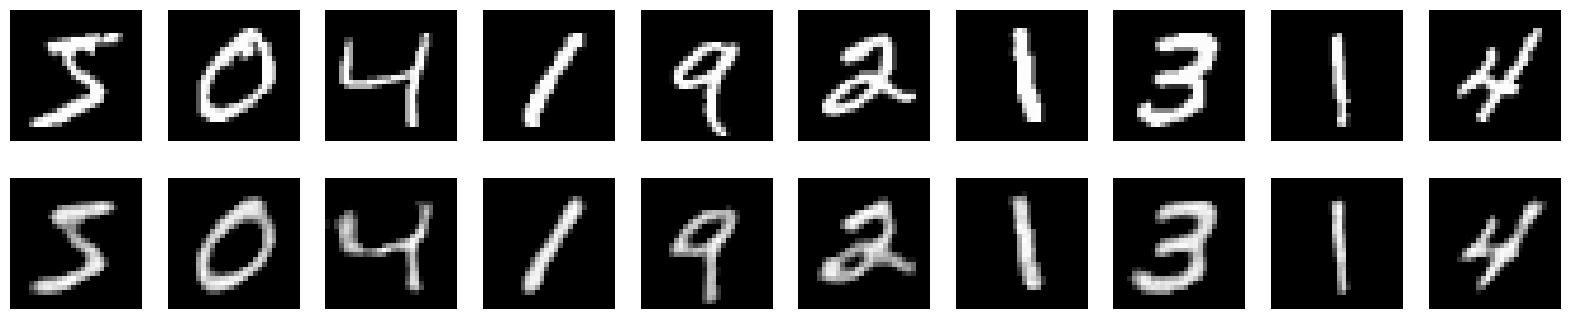

In [ ]:
# show 10 image from dataset and their reconstruction from trained model

fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    img, _ = mnist_trainset[i]
    axs[0, i].imshow(img[0], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(model(img.unsqueeze(0)).detach().numpy()[0][0], cmap='gray')
    axs[1, i].axis('off')

plt.show()